# Remove silents using VAD

Remove silents actually is pretty hard, traditional people use certain dB threshold, if lower, we assume it is a silent with certain window size. If I set -20 dB for one sample audio, does not mean able to do it for another samples.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/remove-silents-vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/remove-silents-vad).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
import librosa
from malaya_speech import Pipeline

In [2]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80)
    return np.log10(np.maximum(mel, 1e-10)).T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    plt.show()

### Load easy example

In [3]:
y, sr = malaya_speech.load('speech/podcast/nusantara.wav')
len(y) / sr

12.27

In [4]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [5]:
ipd.Audio(y, rate = sr)

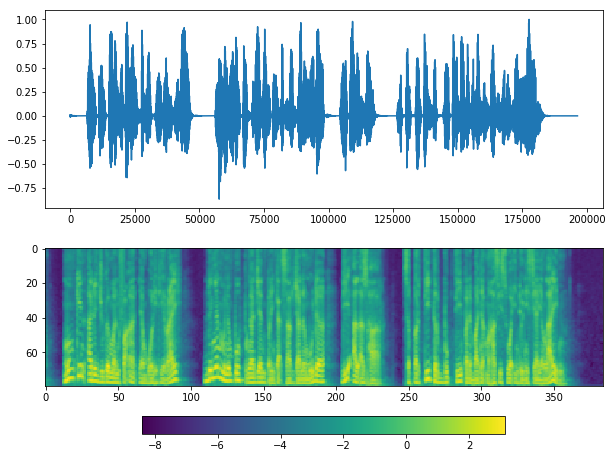

In [6]:
plot(y, sr)

If you see at waveform graph or mel graph, we can see silent periods at the start, middle and end.

#### Use librosa.effects.trim

In [7]:
y_ = librosa.effects.trim(y, top_db = 20)[0]

In [8]:
ipd.Audio(y_, rate = sr)

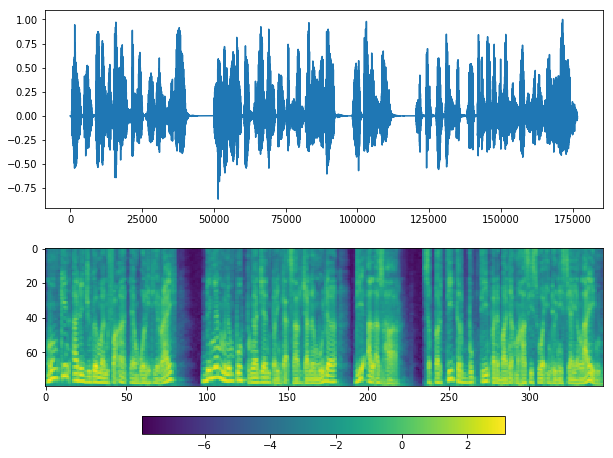

In [9]:
plot(y_, sr)

Looks good, but it missed silents at the middle.

#### Use pydub.silence.split_on_silence

In [10]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

Before changed from float np.array into audiosegment, need to cast to int.

In [11]:
y_int = malaya_speech.astype.float_to_int(y)
audio = AudioSegment(
    y_int.tobytes(), 
    frame_rate = sr,
    sample_width = y_int.dtype.itemsize, 
    channels = 1
)

In [12]:
audio_chunks = split_on_silence(
    audio,
    min_silence_len = 200,
    silence_thresh = -30,
    keep_silence = 100,
)
audio_chunks

In [13]:
y_ = sum(audio_chunks)
y_ = np.array(y_.get_array_of_samples())
y_ = malaya_speech.astype.int_to_float(y_)

In [14]:
ipd.Audio(y_, rate = sr)

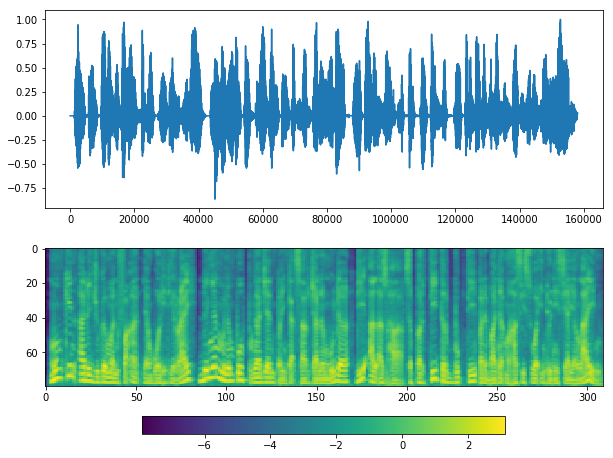

In [15]:
plot(y_, sr)

Looks good, but again, parameter `silence_thresh` is very important.

#### Use WebRTC VAD

We also can split using VAD, good thing about VAD, we do not need to define certain threshold, it depends on how good the VAD model.

In [16]:
vad = malaya_speech.vad.webrtc()

In [17]:
y_= malaya_speech.resample(y, sr, 16000)
y_ = malaya_speech.astype.float_to_int(y_)
frames = malaya_speech.generator.frames(y, 30, sr)
frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]

Or can use pipeline,

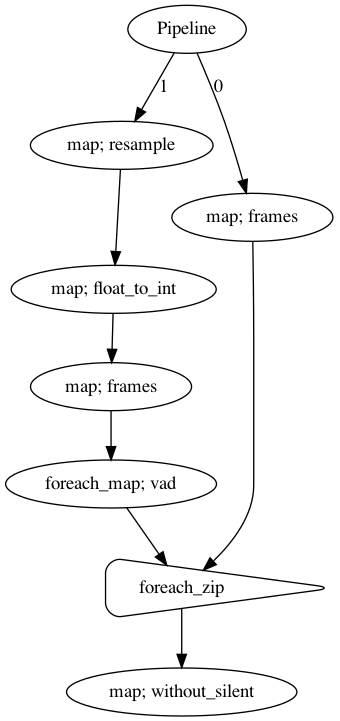

In [18]:
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    p.map(malaya_speech.resample, old_samplerate = sr, new_samplerate = 16000)
    .map(malaya_speech.astype.float_to_int)
    .map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000, 
         append_ending_trail = False)
    .foreach_map(vad)
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent)

p.visualize()

In [19]:
results = p(y)
results.keys()

dict_keys(['frames', 'resample', 'float_to_int', 'vad', 'foreach_zip', 'without_silent'])

In [20]:
y_ = malaya_speech.combine.without_silent(frames_webrtc)
y_

array([-1.83578565e-03,  2.21343555e-03,  5.58967798e-03, ...,
        0.00000000e+00, -1.54295286e-05,  0.00000000e+00])

In [21]:
ipd.Audio(y_, rate = sr)

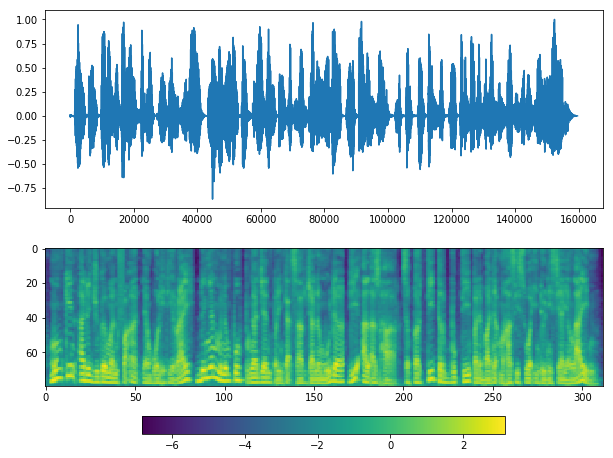

In [22]:
plot(y_, sr)

In [23]:
ipd.Audio(results['without_silent'], rate = sr)

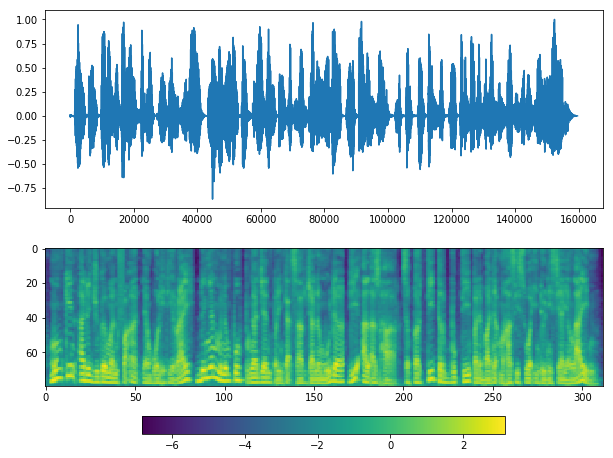

In [24]:
plot(y_, sr)

### Load harder example

In [25]:
y, sr = malaya_speech.load('speech/khutbah/wadi-annuar.wav')
y = y[: sr * 15]
len(y), sr

(160000, 16000)

In [26]:
ipd.Audio(y, rate = sr)

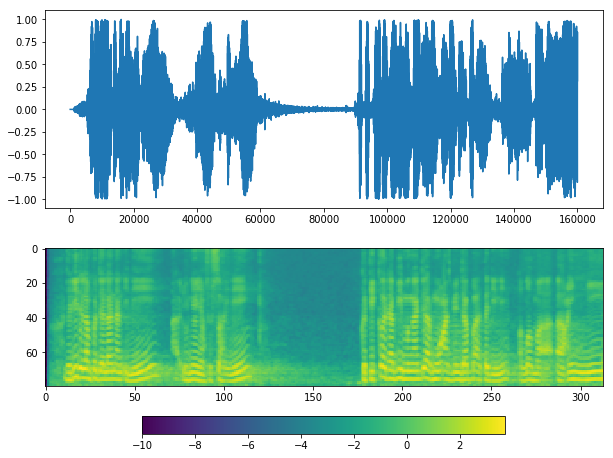

In [27]:
plot(y, sr)

#### Use pydub.silence.split_on_silence

In [28]:
y_int = malaya_speech.astype.float_to_int(y)
audio = AudioSegment(
    y_int.tobytes(), 
    frame_rate = sr,
    sample_width = y_int.dtype.itemsize, 
    channels = 1
)
audio_chunks = split_on_silence(
    audio,
    min_silence_len = 200,
    silence_thresh = -30,
    keep_silence = 100,
)
audio_chunks

In [29]:
y_ = sum(audio_chunks)
y_ = np.array(y_.get_array_of_samples())
y_ = malaya_speech.astype.int_to_float(y_)
ipd.Audio(y_, rate = sr)

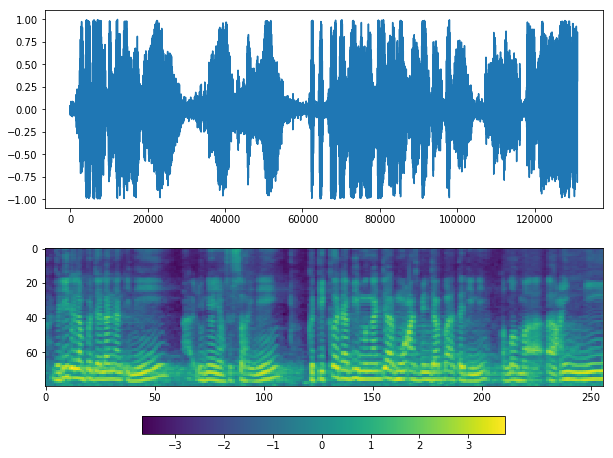

In [30]:
plot(y_, sr)

#### Use WebRTC VAD

In [31]:
results = p(y)
results.keys()

dict_keys(['frames', 'resample', 'float_to_int', 'vad', 'foreach_zip', 'without_silent'])

In [32]:
ipd.Audio(results['without_silent'], rate = sr)

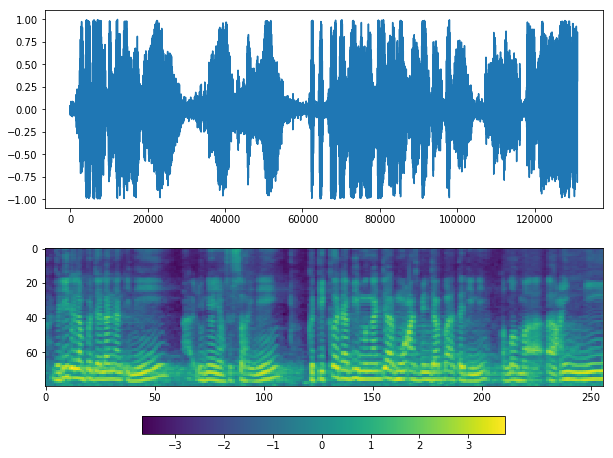

In [33]:
plot(y_, sr)

#### Use Deep learning VAD

In [34]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)

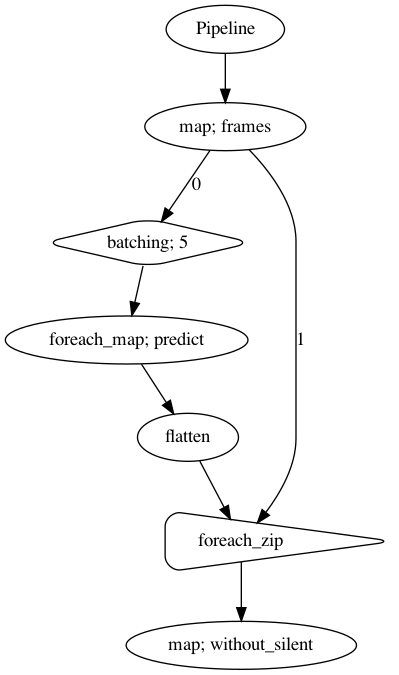

In [35]:
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent, 
                                             threshold_to_stop = 0.05)

p.visualize()

In [36]:
results = p(y)
results.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=160
  n_fft, y.shape[-1]


dict_keys(['frames', 'batching', 'predict', 'flatten', 'foreach_zip', 'without_silent'])

In [37]:
ipd.Audio(results['without_silent'], rate = sr)

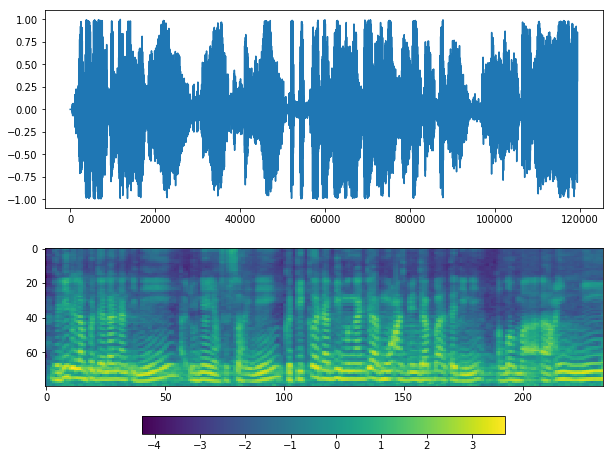

In [38]:
plot(results['without_silent'], sr)